In [1]:

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [17]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
import tensorflow as tf
dataset_path = "/content/drive/MyDrive/PlantVillage"

IMAGE_SIZE = (256,256)
BATCH_SIZE = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,

)
# dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     "/content/drive/MyDrive/PlantVillage",
#     seed=123,
#     shuffle=True,
#     image_size=(IMAGE_SIZE,IMAGE_SIZE),
#     batch_size=BATCH_SIZE
# )

Found 1910 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load pre-trained MobileNetV2 model without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers on top of the pre-trained layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)  # You can adjust the number of neurons in this layer
predictions = Dense(3, activation='softmax')(x)  # Assuming 3 classes in your dataset

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()





9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [18]:
# Assuming you have prepared train_ds, val_ds, and test_ds datasets

# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')


Epoch 1/50
48/48 [==============================] - 13s 278ms/step - loss: 0.2091 - accuracy: 0.9227 - val_loss: 0.3786 - val_accuracy: 0.8802
Epoch 2/50
48/48 [==============================] - 13s 280ms/step - loss: 0.1683 - accuracy: 0.9364 - val_loss: 0.1621 - val_accuracy: 0.9323
Epoch 3/50
48/48 [==============================] - 13s 276ms/step - loss: 0.1383 - accuracy: 0.9495 - val_loss: 0.2137 - val_accuracy: 0.9167
Epoch 4/50
48/48 [==============================] - 14s 285ms/step - loss: 0.1494 - accuracy: 0.9469 - val_loss: 0.1541 - val_accuracy: 0.9427
Epoch 5/50
48/48 [==============================] - 13s 277ms/step - loss: 0.1267 - accuracy: 0.9515 - val_loss: 0.2491 - val_accuracy: 0.9010
Epoch 6/50
48/48 [==============================] - 13s 278ms/step - loss: 0.1469 - accuracy: 0.9423 - val_loss: 0.2627 - val_accuracy: 0.9115
Epoch 7/50
48/48 [==============================] - 13s 277ms/step - loss: 0.1372 - accuracy: 0.9509 - val_loss: 0.1592 - val_accuracy: 0.9479

In [19]:
scores =model.evaluate(test_ds)

6/6 [==============================] - 0s 63ms/step - loss: 0.1534 - accuracy: 0.9531


In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

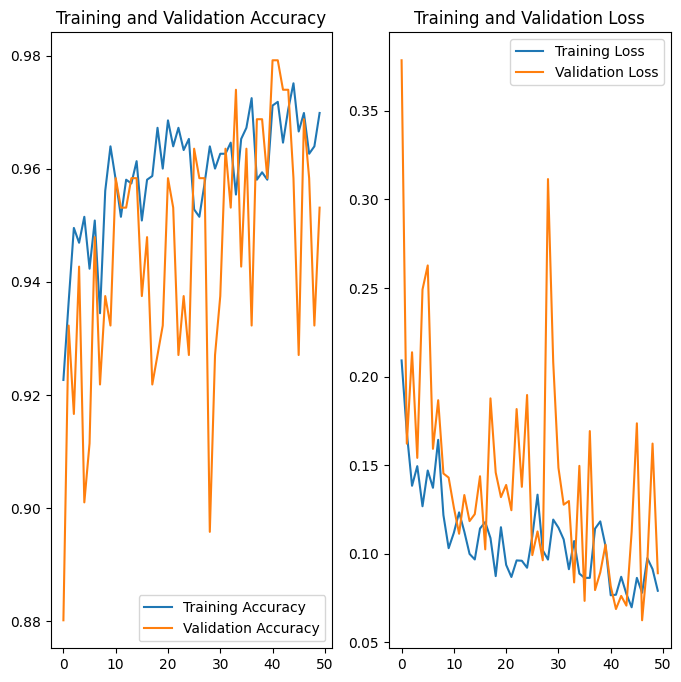

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()